In [3]:
import numpy as np
import numpy.linalg as lg
import cupy as cp
from SPCEj9bbotw.optimizer import gpu_optimizer, ker_main_
from SPCEj9bbotw.functions._plot import plot
import time
import matplotlib.pyplot as plt

c:\Users\user\anaconda3\envs\custom_gpu\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\user\anaconda3\envs\custom_gpu\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


required fuel 1.3235035428715847e-09


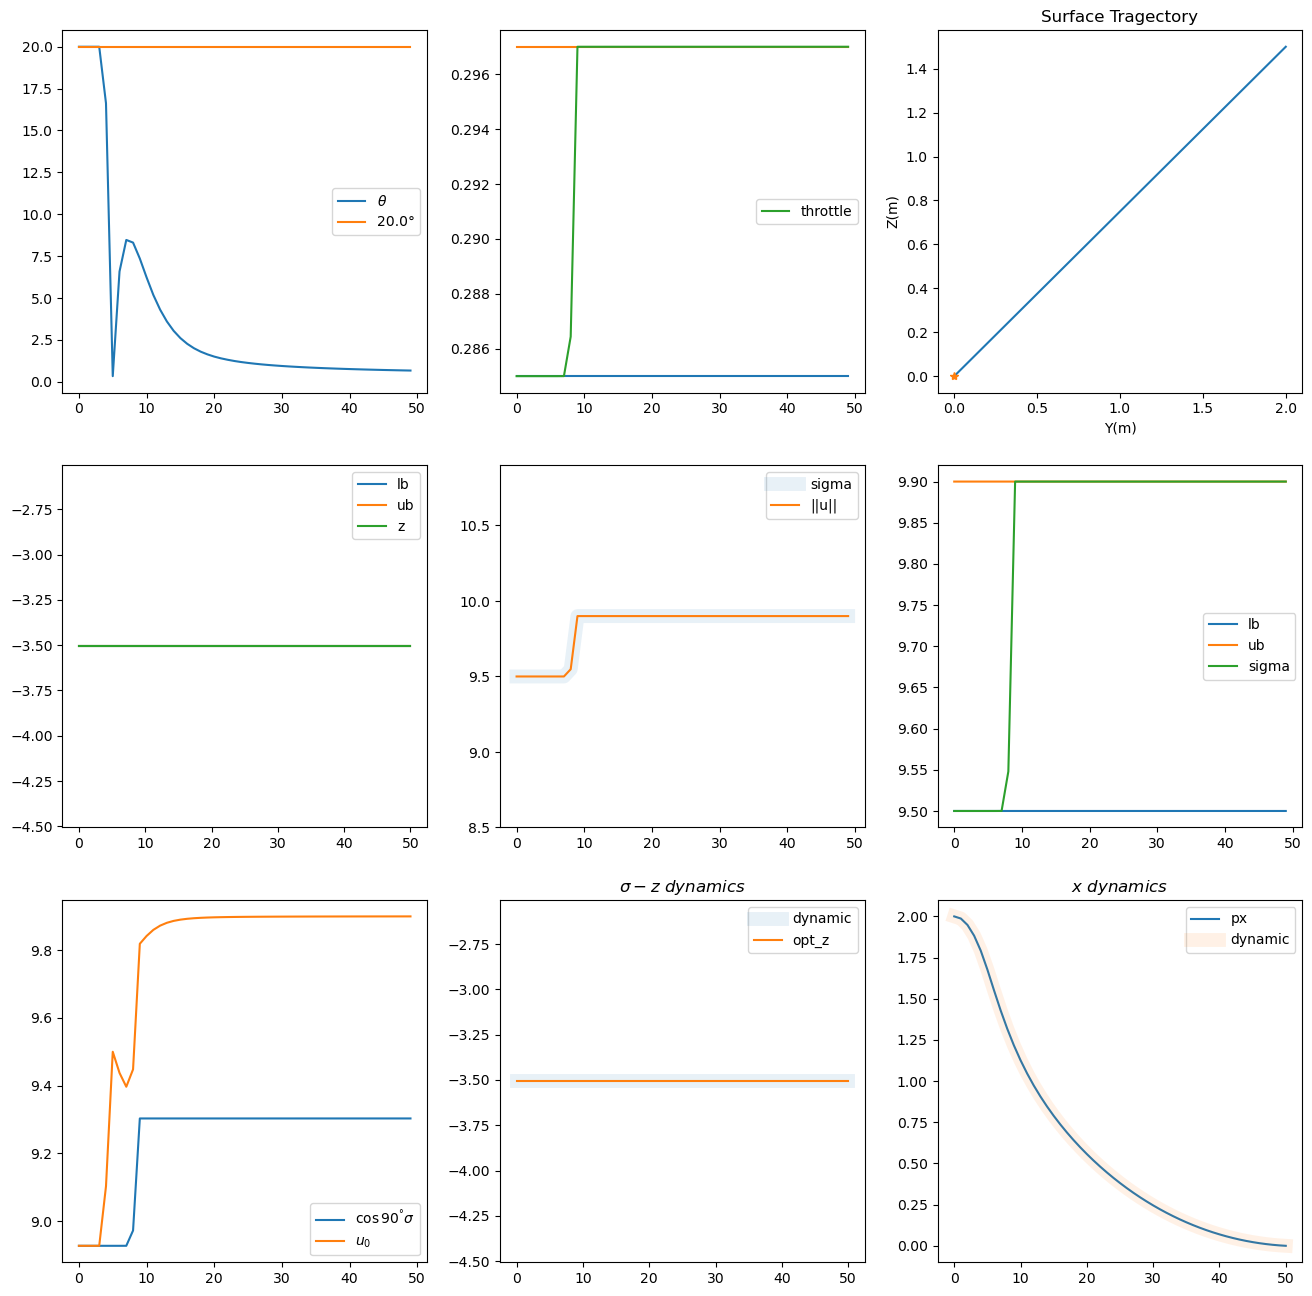

In [4]:
x_0 =np.array([2, 2, 1.5, 0, 0, 0])[:,np.newaxis]
# x_0 =np.array([2.196, 1.906, 1.881, -0.0620, 0, 0])[:,np.newais]

x_des = np.zeros(6)
n = 50
dt = 0.1

init_cond = {'m_0': 0.03, 'm_f': 0.003, 'rho1': 9.5*0.03, 'rho2': 9.9*0.03, 'T_max': 24000, 'alpha': 5e-9, 
            'theta': np.deg2rad(20)}
g = np.array([-9.81, 0, 0])

scl_pos = 1
scl_vel = 1
scl_u = 1
scl_sig = 1
scl_z = 0.1

ang_vel = [0,0,0]
acc_cmd = np.zeros(3)

NR_epoch = 100
mempool = cp.get_default_memory_pool()

func_gpu = ker_main_(n, NR_epoch)
optimizer = gpu_optimizer(x_0, n, dt, 5, init_cond, g, ang_vel, 1000, func_gpu)
optimizer.next_opt(x_0, n, init_cond)
optimizer.scaling((scl_pos, scl_vel, scl_u, scl_sig, scl_z))

optimizer.make_mtrx()
optimizer.init_gpu()
optimizer.admm_main()
acc_cmd = cp.asnumpy(optimizer.acc_cmd_gpu)[:,np.newaxis]

optimizer.epoch = 1000

streams = [cp.cuda.Stream() for i in range(1)]

for i_stream in streams:

    with i_stream:

        t1 = time.time()
        optimizer.next_opt(x_0, n, init_cond)
        optimizer.scaling((scl_pos, scl_vel, scl_u, scl_sig, scl_z))

        optimizer.make_mtrx()
        optimizer.init_gpu()
        optimizer.admm_main()
    
        acc_cmd = cp.asnumpy(optimizer.acc_cmd_gpu)[:,np.newaxis]
        i_stream.synchronize()
        t2 = time.time()
    
    

optimizer.epoch = 0
optimizer.admm_main()

mempool.free_all_blocks()
plot(optimizer)

